<a href="https://colab.research.google.com/github/yeonghun00/stock_public/blob/main/techincals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import ast

class Stock:
  def __init__(self, code):
    self.code = code
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def get_price(self, start:int='20180501', interval='day'):
    url ='https://api.finance.naver.com/siseJson.naver?symbol=' + self.code + ' &requestType=1&startTime=' \
    + start + '&endTime=' + str(datetime.datetime.now().date().strftime("%Y%m%d")) +  '&timeframe=' + interval

    result = requests.get(url)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    b = bs_obj.get_text()
    for i in ['\n', '\t', "\\", ' ']:
      b = b.replace(i,'')

    data = np.array(ast.literal_eval(b)[1:])

    dic = {'Date':list(map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'), data[:,0])), \
      'Open':np.array(data[:,1], int), 'High':np.array(data[:,2], int), 'Low':np.array(data[:,3], int),\
       'Close':np.array(data[:,4], int), 'Volume':np.array(data[:,5], int)}

    df = pd.DataFrame(data=dic)
    df = df.set_index('Date')
    return df
    
  def get_fundamental(self):
    url = 'https://finance.naver.com/item/main.nhn?code=' + self.code
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")

    ths = bs_obj.find_all("th", {'scope':'col'})
    ths = [th.get_text() for th in ths][10:-22]
    dates = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),ths))
    dates = list(map(lambda x: x + '(Y)', dates[:4])) + list(map(lambda x: x + '(M)', dates[4:]))

    tr = bs_obj.find_all("tbody")
    tds = tr[2].find_all('td')
    tds = [td.get_text() for td in tds]
    elements = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),tds))
    elements = list(map(lambda x: float(x) if x.replace('.','').isdigit() else np.nan, elements))

    temp_dict = {}
    cnt = 0
    index = ['sales', 'operating profit', 'net income', 'operating margin', 'net margin', 'roe', 'debt ratio', 'quick ratio', \
    'reserve ratio', 'eps', 'per', 'bps', 'pbr', 'dividend per share', 'dividend yield ratio', 'dividend payout ratio']

    for i in dates:
      temp_dict[i] = elements[cnt::10]
      cnt += 1

    df = pd.DataFrame.from_dict(temp_dict)
    df = df.set_index([pd.Index(index)])
    return df

In [2]:
code = '005930'

stock = Stock(code)
df = stock.get_price('20200101')
df

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,55500,56000,55000,55200,12993228
2020-01-03,56000,56600,54900,55500,15422255
2020-01-06,54900,55600,54600,55500,10278951
2020-01-07,55700,56400,55600,55800,10009778
2020-01-08,56200,57400,55900,56800,23501171
...,...,...,...,...,...
2021-05-14,79000,80300,78900,80100,16450920
2021-05-17,80800,80900,79200,79600,17740855
2021-05-18,79600,80000,79100,79600,17494407


In [3]:
import math

class Technicals:
  def __init__(self, df):
    self.df = df

  def get_mins(self, position='Close', adj_co=5):
      new_dict = {'date': [], position: []}
      for i in range(df.shape[0]):
          if (i - adj_co >= 0 and i + adj_co < df.shape[0]):
              if min(self.df.loc[self.df.index[i - adj_co:i + adj_co]][position].values) >= self.df.loc[self.df.index[i]][position]:
                  new_dict['date'].append(self.df.index[i])
                  new_dict[position].append(self.df.loc[self.df.index[i]][position])
              else:
                  new_dict['date'].append(self.df.index[i])
                  new_dict[position].append(None)
          else:
              new_dict['date'].append(self.df.index[i])
              new_dict[position].append(None)

      new_df = pd.DataFrame.from_dict(new_dict)
      new_df = new_df.set_index('date')

      return new_df

  def get_maxs(self, position='Close', adj_co=5):
      new_dict = {'date': [], position: []}
      for i in range(df.shape[0]):
          if (i - adj_co >= 0 and i + adj_co < df.shape[0]):
              if max(self.df.loc[self.df.index[i - adj_co:i + adj_co]][position].values) <= self.df.loc[self.df.index[i]][position]:
                  new_dict['date'].append(self.df.index[i])
                  new_dict[position].append(self.df.loc[self.df.index[i]][position])
              else:
                  new_dict['date'].append(self.df.index[i])
                  new_dict[position].append(None)
          else:
              new_dict['date'].append(self.df.index[i])
              new_dict[position].append(None)

      new_df = pd.DataFrame.from_dict(new_dict)
      new_df = new_df.set_index('date')

      return new_df

  def get_closeness(self, pos:str='max', adj_co:int=5)->list:
    if pos == 'min':
      li = [x for x in self.get_mins('Close', adj_co)['Close'] if not math.isnan(x)]
    elif pos == 'max':
      li = [x for x in self.get_maxs('Close', adj_co)['Close'] if not math.isnan(x)]
    current = self.df.iloc[-1]['Close']

    return li/current

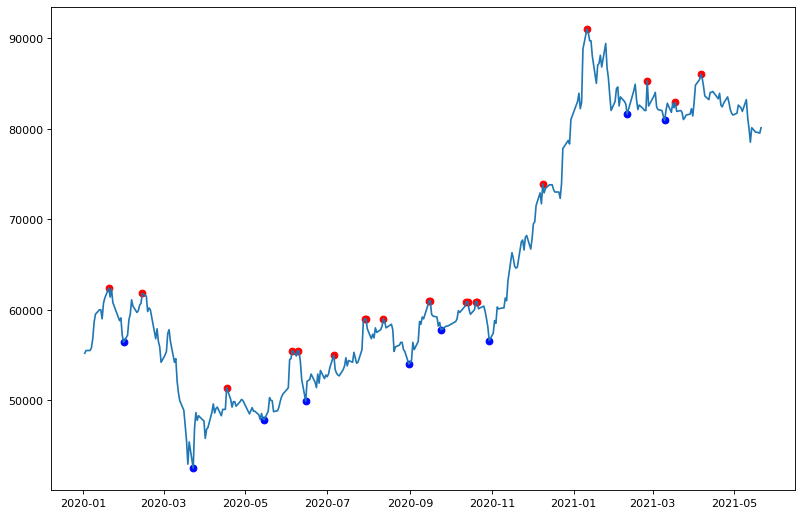

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

tech = Technicals(df)
figure(figsize=(12, 8), dpi=80)
plt.plot(df['Close'])
plt.scatter(x = df.index, y = tech.get_maxs('Close', 10), c='#ff0000', marker = 'o')
plt.scatter(x = df.index, y = tech.get_mins('Close', 10), c='#0008ff', marker = 'o')

In [5]:
tech.get_closeness('max', 10)

# find max among, cal increase prob
# find distance ==> (weight)

array([0.77902622, 0.7627965 , 0.77153558, 0.721598  , 0.60736579,
       0.61922597, 0.64169788, 0.62546816, 0.62796504, 0.6928839 ,
       0.6928839 , 0.66042447, 0.66541823, 0.6866417 , 0.73657928,
       0.73657928, 0.73657928, 0.76154806, 0.76154806, 0.76029963,
       0.76029963, 0.76029963, 0.76029963, 0.82771536, 0.92259675,
       1.1360799 , 1.11610487, 1.05992509, 1.06491885, 1.0349563 ,
       1.07365793, 1.03870162])